# Analyse FEP outputs

In [1]:
%pylab inline
from networkanalysis_local import NetworkAnalyser
import experiments_local as n_ex
import stats_local as n_stats

import csv
import numpy as np
import pandas as pd 

Populating the interactive namespace from numpy and matplotlib


## 1. Load FEP output data.

### Variables

In [2]:
# a CSV file output by SOMD that contains perturbation name,free energy,confidence.
results_filepath = 'outputs/fep_outputs/summary.csv'

# experimental values (e.g. ic50/ki) for all ligands in our set. This is optional.
exp_filepath = 'inputs/exp_data_tyk2.dat'

# if we have added any intermediate ligands, define the regular expression here. Ligands 
# containing this pattern will be excluded from calculations that compare to experimental values.
intermediate_string = 'jul' # if you want to exclude an intermediate, just input as string as well, e.g. 'jul'

Now that we have run all our simulations (which should have appended results to a file - in our case "summary.csv"), we can start analysing our results. Additionally, we would like to compare our predictions to experimental measures.

We use FreeNrgWorkFlows (https://github.com/michellab/freenrgworkflows) to analyse our predictions. Instead of just computing $\Delta\Delta$G values for each transformation, we would like to estimate the $\Delta$G value for each individual ligand. There are some involved algorithms needed for these steps which is what FreeNrgWorkFlows takes care of for us.

In [40]:
nA = NetworkAnalyser()
nA.read_perturbations_pandas(results_filepath, comments='#')

computed_relative_DDGs = nA.freeEnergyInKcal

/home/jscheen/projects/BioSimSpaceTutorials/03_fep/networkanalysis_local.py:128: UserWarning: Provided network is not fully connected doing analysis on subgraph
  warnings.warn('Provided network is not fully connected doing analysis on subgraph')


[{'ejm31': -0.12671568627450963, 'error': 0.5237207721052144},
 {'ejm42': -0.4600490196078435, 'error': 0.6530782854505192},
 {'ejm43': 0.5232843137254898, 'error': 0.8722187406918029},
 {'ejm44': 2.756617647058823, 'error': 0.8710476396658645},
 {'ejm45': -0.5267156862745097, 'error': 0.6470362444504795},
 {'ejm46': -0.7079656862745096, 'error': 0.7900900311610476},
 {'ejm47': 0.42328431372549036, 'error': 0.8803900297609811},
 {'ejm48': 0.27328431372549056, 'error': 1.1279300618926211},
 {'ejm49': 0.22328431372549054, 'error': 0.8855263118308017},
 {'ejm50': 0.15661764705882367, 'error': 0.7227412526582382},
 {'ejm54': -0.8433823529411767, 'error': 0.9044110161832155},
 {'ejm55': -0.8267156862745101, 'error': 0.93045348186946},
 {'jmc23': -0.7954656862745099, 'error': 0.9989685597969489},
 {'jmc27': -0.5454656862745098, 'error': 1.0021769199218418},
 {'jmc28': 0.3545343137254904, 'error': 0.8056308457962591},
 {'jmc30': -1.1017156862745099, 'error': 0.9872925462153077},
 {'jul_01': 1

## 2. Load experimental data (if available) and compile into pandas.
In cases where experimental data is available, for instance when benchmarking a new protein-ligand set, we would like to compare how well FEP is predicting with respect to these data. Using Pandas, we can work with our data in an intuitive way that is easy to use for plotting graphs.

Load the experimental data. 

In [10]:
experiments = n_ex.ExperimentalData()

experiments.compute_affinities(exp_filepath, data_type="IC50", comments="#", delimiter=",")
experimental_DDGs = experiments.freeEnergiesInKcal


For plotting it is typically easier to work with the pandas library. This next bit of code reshapes the data into a dataframe format. 

Note that if pandas returns value errors at this step, it is likely there are ligands missing from either your FEP outputs or your experimental input.

In [5]:
freenrg_dict = {}

# construct dict with experimental freenrg and error.
for item in experimental_DDGs:

    ligand = list(item.keys())[0]
    freenrg = list(item.values())[0]
    error = list(item.values())[1]
    freenrg_dict[ligand] = [freenrg, error]
freenrg_dict
# append computed freenrg and error.
for item in computed_relative_DDGs:
        ligand = list(item.keys())[0]
        freenrg = list(item.values())[0]
        error = list(item.values())[1]
        
        if intermediate_string not in ligand:
            freenrg_dict[ligand].append(freenrg)
            freenrg_dict[ligand].append(error)

freenrg_df = pd.DataFrame(freenrg_dict, index=["freenrg_exp", "err_exp", "freenrg_fep", "err_fep"]).transpose()

# save our results to a file that can be opened in e.g. Excel.
freenrg_df.to_csv("outputs/fep_results_table.csv")


freenrg_df

,freenrg_exp,err_exp,freenrg_fep,err_fep
ejm31,0.203939,0.413227,-0.126716,0.521526
ejm42,-0.037783,0.413227,-0.460049,0.643465
ejm43,1.497045,0.413227,0.523284,0.873019
ejm44,2.347836,0.413227,2.756618,0.877263
ejm45,0.191388,0.413227,-0.526716,0.656374
ejm46,-1.582000,0.413227,-0.707966,0.783583
ejm47,0.048769,0.413227,0.423284,0.886535
ejm48,0.750196,0.413227,0.273284,1.137849
ejm49,2.014215,0.413227,0.223284,0.888468
ejm50,0.774533,0.413227,0.156618,0.721682


## 3. Plot data with statistics.
There are several ways to plot FEP results comparing them to experimental data. In this tutorial, we will use matplotlib and seaborn to plot a bargraph and a scatterplot, while also depicting statistics with confidence bounds. Combining these should give a good indication of whether our FEP method is able to predict reliably.

### 3.1. Barplot

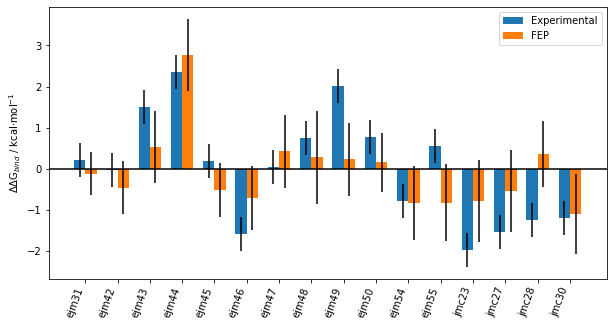

In [6]:
# initiate an empty figure with fixed dimensions.
fig, ax = plt.subplots(figsize=(10,5))

# determine positions for X axis labels.
x_locs = np.arange(len(freenrg_df))

# set bar width
width = 0.35  

# plot both our experimental and FEP free energies using an offset on the x position so bars don't overlap.
ax.bar(x_locs - width/2, height=freenrg_df["freenrg_exp"], width=width, yerr=freenrg_df["err_exp"],
                label='Experimental')
ax.bar(x_locs + width/2, height=freenrg_df["freenrg_fep"], width=width, yerr=freenrg_df["err_fep"],
                label='FEP')
 
# format the plot further.
plt.axhline(color="black")
plt.ylabel("$\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
plt.xticks(x_locs, freenrg_df.index, rotation=70, ha="right")
plt.legend()

plt.savefig("outputs/fep_vs_exp_barplot.png", dpi=300)
plt.show()

### 3.2. Scatterplot

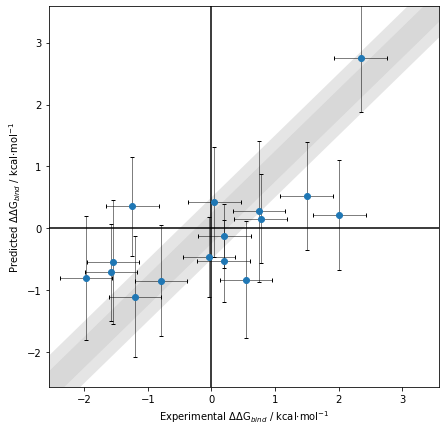

In [25]:
plt.figure(figsize=(7,7))

plt.scatter(freenrg_df["freenrg_exp"], freenrg_df["freenrg_fep"], zorder=10)

# plot 1/2 kcal bounds:
plt.fill_between(
				x=[-100, 100], 
				y2=[-100.25,99.75],
				y1=[-99.75, 100.25],
				lw=0, 
				zorder=-10,
				alpha=0.3,
				color="grey")
# upper bound:
plt.fill_between(
				x=[-100, 100], 
				y2=[-99.5,100.5],
				y1=[-99.75, 100.25],
				lw=0, 
				zorder=-10,
				color="grey", 
				alpha=0.2)
# lower bound:
plt.fill_between(
				x=[-100, 100], 
				y2=[-100.25,99.75],
				y1=[-100.5, 99.5],
				lw=0, 
				zorder=-10,
				color="grey", 
				alpha=0.2)

# plot error bars:
yerr = freenrg_df["err_fep"]
xerr = freenrg_df["err_exp"]

plt.errorbar(freenrg_df["freenrg_exp"], freenrg_df["freenrg_fep"], 
            yerr=yerr,
            xerr=xerr,   # comment this line to hide experimental error bars \
                         # as this can sometimes overcrowd the plot.
            ls="none",
            lw=0.5, 
            capsize=2,
            color="black",
            zorder=5
            )

# format the plot further.
plt.axhline(color="black", zorder=1)
plt.axvline(color="black", zorder=1)
plt.ylabel("Predicted $\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
plt.xlabel("Experimental $\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")

# get the bounds. This can be done with min/max or simply by hand.
all_freenrg_values = np.concatenate([freenrg_df["freenrg_exp"].values,freenrg_df["freenrg_fep"].values])
min_lim = min(all_freenrg_values)
max_lim = max(all_freenrg_values)

# for a scatterplot we want the axis ranges to be the same. 
plt.xlim(min_lim*1.3, max_lim*1.3)
plt.ylim(min_lim*1.3, max_lim*1.3)

plt.savefig("outputs/fep_vs_exp_scatterplot.png", dpi=300)
plt.show()

### 3.3. Statistical analysis.
Error analysis on typical statistical measures: R, Mean Unsigned/Absolute Error (MUE) and Kendall Tau.

Below are examples of how to re-sample from the data in order to obtain error bars on correlation coefficients,
MUE and Kendall tau. Returned are confidence intervals of 65% and the median of the distribution. It is important to take these confidences into account as FEP predictions have a variance associated with them.

In [8]:
    stats = n_stats.freeEnergyStats()
    stats.generate_statistics(computed_relative_DDGs,experimental_DDGs,repeats=10000)
    r_confidence = stats.R_confidence
    tau_confidence = stats.tau_confidence
    mue_confidence = stats.mue_confidence
    print ("R confidence is:   %.2f < %.2f < %.2f" %(r_confidence[1], r_confidence[0], r_confidence[2]))
    print ("MUE confidence is: %.2f < %.2f < %.2f" %(mue_confidence[1], mue_confidence[0], mue_confidence[2]))
    print ("Tau confidence is: %.2f < %.2f < %.2f" %(tau_confidence[1], tau_confidence[0], tau_confidence[2]))

R confidence is:   0.45 < 0.52 < 0.59
MUE confidence is: 0.92 < 1.00 < 1.08
Tau confidence is: 0.25 < 0.32 < 0.40


## 4. Final notes

#### An example custom plot: outlier annotation.
Using some code to determine which data points to annotate, we can display their names on the scatter plot:

In [ ]:
number_outliers_to_annotate = 3

# get an array of the MUE values comparing experimental and FEP values. Take the absolute values.
mue_values = abs(freenrg_df["freenrg_exp"] - freenrg_df["freenrg_fep"])

# find the n ligand names that are outliers.
outlier_names = mue_values.nlargest(number_outliers_to_annotate).index.values.tolist()

# construct a list of labels to annotate the scatterplot with.
annot_labels = []
for ligand in freenrg_df.index.values:
    # if the ligand is an outlier, append the name to the annotation labels list.
    if ligand in outlier_names:
        annot_labels.append(ligand)
    else:
        # if the ligand is not an outlier, append an empty string to the annotation labels list.
        annot_labels.append("")

# then, after generating the figure, we can annotate:
for i, txt in enumerate(annot_labels):
    plt.annotate(txt, 
                 (freenrg_df["freenrg_exp"].values.tolist()[i]+0.1,     # x coords
                  freenrg_df["freenrg_fep"].values.tolist()[i]+0.1),    # y coords
                 size=20, color="crimson")

#### In case of no experimental measures, just plot the FEP predictions

In [ ]:
# initiate an empty figure with fixed dimensions.
fig, ax = plt.subplots(figsize=(10,5))

# determine positions for X axis labels.
x_locs = np.arange(len(freenrg_df))

# set bar width
width = 0.35  

# plot both our FEP energies.
ax.bar(x_locs, height=freenrg_df["freenrg_fep"], width=width, yerr=freenrg_df["err_fep"])

# format the plot further.
plt.axhline(color="black")
plt.ylabel("$\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
plt.xticks(x_locs, freenrg_df.index, rotation=70, ha="right")

plt.savefig("outputs/fep_barplot.png", dpi=300)
plt.show()